**12장 – 텐서플로를 사용한 사용자 정의 모델과 훈련**

_이 노트북에는 12장의 모든 샘플 코드와 연습 문제에 대한 해답, 부록 C의 코드 예제가 포함되어 있습니다_.

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/rickiepark/handson-ml3/blob/main/12_custom_models_and_training_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# 설정

이 프로젝트에는 Python 3.7 이상이 필요합니다:

In [1]:
import sys

assert sys.version_info >= (3, 7)

그리고 TensorFlow ≥ 2.8:

In [2]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [3]:
import sys
# 코랩의 경우 나눔 폰트를 설치합니다.
if 'google.colab' in sys.modules:
    !sudo apt-get -qq -y install fonts-nanum
    import matplotlib.font_manager as fm
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

# 나눔 폰트를 사용합니다.
import matplotlib

matplotlib.rc('font', family='NanumBarunGothic')
matplotlib.rcParams['axes.unicode_minus'] = False

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121752 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


## 넘파이처럼 텐서플로 사용하기

### 텐서 및 연산

#### 텐서

In [4]:
t = tf.constant([[1., 2., 3.], [4., 5., 6.]]) # 행렬
t

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [5]:
t.shape

TensorShape([2, 3])

In [6]:
t.dtype

tf.float32

#### 인덱싱

In [7]:
t[:, 1:]

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[2., 3.],
       [5., 6.]], dtype=float32)>

In [8]:
t[..., 1, tf.newaxis]

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[2.],
       [5.]], dtype=float32)>

#### 연산

In [9]:
t + 10

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[11., 12., 13.],
       [14., 15., 16.]], dtype=float32)>

In [10]:
tf.square(t)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)>

In [11]:
t @ tf.transpose(t)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[14., 32.],
       [32., 77.]], dtype=float32)>

#### 스칼라

In [12]:
tf.constant(42)

<tf.Tensor: shape=(), dtype=int32, numpy=42>

#### 케라스의 저수준 API

여전히 케라스 저수준 API를 사용하는 코드를 실행할 수 있습니다:

In [13]:
K = tf.keras.backend
K.square(K.transpose(t)) + 10

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[11., 26.],
       [14., 35.],
       [19., 46.]], dtype=float32)>

하지만 케라스는 더 이상 멀티 백엔드를 지원하지 않으므로 대신 TF의 저수준 API를 직접 사용해야 합니다:

In [14]:
tf.square(tf.transpose(t)) + 10

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[11., 26.],
       [14., 35.],
       [19., 46.]], dtype=float32)>

### 텐서와 넘파이

In [15]:
import numpy as np

a = np.array([2., 4., 5.])
tf.constant(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([2., 4., 5.])>

In [16]:
t.numpy()

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [17]:
np.array(t)

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [18]:
tf.square(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([ 4., 16., 25.])>

In [19]:
np.square(t)

array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)

### 타입 변환

In [20]:
try:
    tf.constant(2.0) + tf.constant(40)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a int32 tensor [Op:AddV2] name: 


In [21]:
try:
    tf.constant(2.0) + tf.constant(40., dtype=tf.float64)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a double tensor [Op:AddV2] name: 


In [22]:
t2 = tf.constant(40., dtype=tf.float64)
tf.constant(2.0) + tf.cast(t2, tf.float32)

<tf.Tensor: shape=(), dtype=float32, numpy=42.0>

### 변수

In [23]:
v = tf.Variable([[1., 2., 3.], [4., 5., 6.]])
v

<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [24]:
v.assign(2 * v)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2.,  4.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [25]:
v[0, 1].assign(42)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [26]:
v[:, 2].assign([0., 1.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  0.],
       [ 8., 10.,  1.]], dtype=float32)>

In [27]:
v.scatter_nd_update(
    indices=[[0, 0], [1, 2]], updates=[100., 200.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[100.,  42.,   0.],
       [  8.,  10., 200.]], dtype=float32)>

In [28]:
# 추가 코드 - scatter_update() 사용 방법을 보여줍니다.
sparse_delta = tf.IndexedSlices(values=[[1., 2., 3.], [4., 5., 6.]],
                                indices=[1, 0])
v.scatter_update(sparse_delta)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[4., 5., 6.],
       [1., 2., 3.]], dtype=float32)>

In [29]:
try:
    v[1] = [7., 8., 9.]
except TypeError as ex:
    print(ex)

'ResourceVariable' object does not support item assignment


### 문자열

이 섹션과 이후 섹션의 코드는 부록 C에 해당합니다.

In [30]:
tf.constant(b"hello world")

<tf.Tensor: shape=(), dtype=string, numpy=b'hello world'>

In [31]:
tf.constant("café")

<tf.Tensor: shape=(), dtype=string, numpy=b'caf\xc3\xa9'>

In [32]:
u = tf.constant([ord(c) for c in "café"])
u

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 99,  97, 102, 233], dtype=int32)>

In [33]:
b = tf.strings.unicode_encode(u, "UTF-8")
tf.strings.length(b, unit="UTF8_CHAR")

<tf.Tensor: shape=(), dtype=int32, numpy=4>

In [34]:
tf.strings.unicode_decode(b, "UTF-8")

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 99,  97, 102, 233], dtype=int32)>

### 다른 데이터 구조

이 섹션의 코드는 부록 C에 있습니다.

#### 문자열 배열

In [35]:
tf.constant(b"hello world")

<tf.Tensor: shape=(), dtype=string, numpy=b'hello world'>

In [36]:
tf.constant("café")

<tf.Tensor: shape=(), dtype=string, numpy=b'caf\xc3\xa9'>

In [37]:
u = tf.constant([ord(c) for c in "café"])
u

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 99,  97, 102, 233], dtype=int32)>

In [38]:
b = tf.strings.unicode_encode(u, "UTF-8")
b

<tf.Tensor: shape=(), dtype=string, numpy=b'caf\xc3\xa9'>

In [39]:
tf.strings.length(b, unit="UTF8_CHAR")

<tf.Tensor: shape=(), dtype=int32, numpy=4>

In [40]:
tf.strings.unicode_decode(b, "UTF-8")

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 99,  97, 102, 233], dtype=int32)>

In [41]:
p = tf.constant(["Café", "Coffee", "caffè", "咖啡"])

In [42]:
tf.strings.length(p, unit="UTF8_CHAR")

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([4, 6, 5, 2], dtype=int32)>

In [43]:
r = tf.strings.unicode_decode(p, "UTF8")
r

<tf.RaggedTensor [[67, 97, 102, 233], [67, 111, 102, 102, 101, 101],
 [99, 97, 102, 102, 232], [21654, 21857]]>

#### 래그드 텐서

In [44]:
r[1]

<tf.Tensor: shape=(6,), dtype=int32, numpy=array([ 67, 111, 102, 102, 101, 101], dtype=int32)>

In [45]:
r[1:3]  # 추가 코드 - 래그드 텐서의 슬라이스는 래그드 텐서입니다.

<tf.RaggedTensor [[67, 111, 102, 102, 101, 101], [99, 97, 102, 102, 232]]>

In [46]:
r2 = tf.ragged.constant([[65, 66], [], [67]])
tf.concat([r, r2], axis=0)

<tf.RaggedTensor [[67, 97, 102, 233], [67, 111, 102, 102, 101, 101],
 [99, 97, 102, 102, 232], [21654, 21857], [65, 66], [], [67]]>

In [47]:
r3 = tf.ragged.constant([[68, 69, 70], [71], [], [72, 73]])
print(tf.concat([r, r3], axis=1))

<tf.RaggedTensor [[67, 97, 102, 233, 68, 69, 70], [67, 111, 102, 102, 101, 101, 71],
 [99, 97, 102, 102, 232], [21654, 21857, 72, 73]]>


In [48]:
r.to_tensor()

<tf.Tensor: shape=(4, 6), dtype=int32, numpy=
array([[   67,    97,   102,   233,     0,     0],
       [   67,   111,   102,   102,   101,   101],
       [   99,    97,   102,   102,   232,     0],
       [21654, 21857,     0,     0,     0,     0]], dtype=int32)>

#### 희소 텐서

In [49]:
s = tf.SparseTensor(indices=[[0, 1], [1, 0], [2, 3]],
                    values=[1., 2., 3.],
                    dense_shape=[3, 4])

In [50]:
tf.sparse.to_dense(s)

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0., 1., 0., 0.],
       [2., 0., 0., 0.],
       [0., 0., 0., 3.]], dtype=float32)>

In [51]:
s * 42.0

SparseTensor(indices=tf.Tensor(
[[0 1]
 [1 0]
 [2 3]], shape=(3, 2), dtype=int64), values=tf.Tensor([ 42.  84. 126.], shape=(3,), dtype=float32), dense_shape=tf.Tensor([3 4], shape=(2,), dtype=int64))

In [52]:
try:
    s + 42.0
except TypeError as ex:
    print(ex)

unsupported operand type(s) for +: 'SparseTensor' and 'float'


In [53]:
# 추가 코드 - 희소 텐서와 밀집 텐서를 곱하는 방법을 보여줍니다.
s4 = tf.constant([[10., 20.], [30., 40.], [50., 60.], [70., 80.]])
tf.sparse.sparse_dense_matmul(s, s4)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[ 30.,  40.],
       [ 20.,  40.],
       [210., 240.]], dtype=float32)>

In [54]:
# 추가 코드 - 희소 텐서를 생성할 때 값을 "읽는 순서"로 제공해야 하며, 그렇지 않으면 `to_dense()`가 실패합니다.
s5 = tf.SparseTensor(indices=[[0, 2], [0, 1]],  # 잘못된 순서!
                     values=[1., 2.],
                     dense_shape=[3, 4])
try:
    tf.sparse.to_dense(s5)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

{{function_node __wrapped__SparseToDense_device_/job:localhost/replica:0/task:0/device:GPU:0}} indices[1] is out of order. Many sparse ops require sorted indices.
  Use `tf.sparse.reorder` to create a correctly ordered copy.


	 [[{{node SparseToDense}}]] [Op:SparseToDense] name: 


In [55]:
# 추가 코드 - 희소 텐서 s5의 값을 재정렬하여 수정하는 방법을 보여줍니다.
s6 = tf.sparse.reorder(s5)
tf.sparse.to_dense(s6)

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0., 2., 1., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)>

#### 텐서 배열

In [56]:
array = tf.TensorArray(dtype=tf.float32, size=3)
array = array.write(0, tf.constant([1., 2.]))
array = array.write(1, tf.constant([3., 10.]))
array = array.write(2, tf.constant([5., 7.]))
tensor1 = array.read(1)  # tf.constant([3., 10.])을 반환하고 (0으로 채웁니다!)

In [57]:
array.stack()

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[1., 2.],
       [0., 0.],
       [5., 7.]], dtype=float32)>

In [58]:
# 추가 코드 - clear_after_read를 비활성화하는 방법을 보여줍니다.
array2 = tf.TensorArray(dtype=tf.float32, size=3, clear_after_read=False)
array2 = array2.write(0, tf.constant([1., 2.]))
array2 = array2.write(1, tf.constant([3., 10.]))
array2 = array2.write(2, tf.constant([5., 7.]))
tensor2 = array2.read(1)  # tf.constant([3., 10.])를 반환합니다.
array2.stack()

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[ 1.,  2.],
       [ 3., 10.],
       [ 5.,  7.]], dtype=float32)>

In [59]:
# 추가 코드 - 동적 크기의 텐서 배열을 생성하고 사용하는 방법을 보여줍니다.
array3 = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
array3 = array3.write(0, tf.constant([1., 2.]))
array3 = array3.write(1, tf.constant([3., 10.]))
array3 = array3.write(2, tf.constant([5., 7.]))
tensor3 = array3.read(1)
array3.stack()

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[1., 2.],
       [0., 0.],
       [5., 7.]], dtype=float32)>

#### 집합

In [60]:
a = tf.constant([[1, 5, 9]])
b = tf.constant([[5, 6, 9, 11]])
u = tf.sets.union(a, b)
u

SparseTensor(indices=tf.Tensor(
[[0 0]
 [0 1]
 [0 2]
 [0 3]
 [0 4]], shape=(5, 2), dtype=int64), values=tf.Tensor([ 1  5  6  9 11], shape=(5,), dtype=int32), dense_shape=tf.Tensor([1 5], shape=(2,), dtype=int64))

In [61]:
tf.sparse.to_dense(u)

<tf.Tensor: shape=(1, 5), dtype=int32, numpy=array([[ 1,  5,  6,  9, 11]], dtype=int32)>

In [62]:
a = tf.constant([[1, 5, 9], [10, 0, 0]])
b = tf.constant([[5, 6, 9, 11], [13, 0, 0, 0]])
u = tf.sets.union(a, b)
tf.sparse.to_dense(u)

<tf.Tensor: shape=(2, 5), dtype=int32, numpy=
array([[ 1,  5,  6,  9, 11],
       [ 0, 10, 13,  0,  0]], dtype=int32)>

In [63]:
# 추가 코드 - 다른 기본값(이 경우 -1)을 사용하는 방법을 보여줍니다.
a = tf.constant([[1, 5, 9], [10, -1, -1]])
b = tf.constant([[5, 6, 9, 11], [13, -1, -1, -1]])
u = tf.sets.union(a, b)
tf.sparse.to_dense(u, default_value=-1)

<tf.Tensor: shape=(2, 5), dtype=int32, numpy=
array([[ 1,  5,  6,  9, 11],
       [-1, 10, 13, -1, -1]], dtype=int32)>

In [64]:
# 추가 코드 - `tf.sets.difference()`를 사용하는 방법을 보여줍니다.
set1 = tf.constant([[2, 3, 5, 7], [7, 9, 0, 0]])
set2 = tf.constant([[4, 5, 6], [9, 10, 0]])
tf.sparse.to_dense(tf.sets.difference(set1, set2))

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[2, 3, 7],
       [7, 0, 0]], dtype=int32)>

In [65]:
# 추가 코드 - `tf.sets.difference()`를 사용하는 방법을 보여줍니다.
tf.sparse.to_dense(tf.sets.intersection(set1, set2))

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[5, 0],
       [0, 9]], dtype=int32)>

In [66]:
# 추가 코드 - set1[0]에 5가 포함되어 있는지 확인합니다.
tf.sets.size(tf.sets.intersection(set1[:1], tf.constant([[5, 0, 0, 0]]))) > 0

<tf.Tensor: shape=(1,), dtype=bool, numpy=array([ True])>

#### 큐

In [67]:
q = tf.queue.FIFOQueue(3, [tf.int32, tf.string], shapes=[(), ()])
q.enqueue([10, b"windy"])
q.enqueue([15, b"sunny"])
q.size()

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [68]:
q.dequeue()

[<tf.Tensor: shape=(), dtype=int32, numpy=10>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'windy'>]

In [69]:
q.enqueue_many([[13, 16], [b'cloudy', b'rainy']])

In [70]:
q.dequeue_many(3)

[<tf.Tensor: shape=(3,), dtype=int32, numpy=array([15, 13, 16], dtype=int32)>,
 <tf.Tensor: shape=(3,), dtype=string, numpy=array([b'sunny', b'cloudy', b'rainy'], dtype=object)>]

## 사용자 정의 손실

In [71]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss  = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

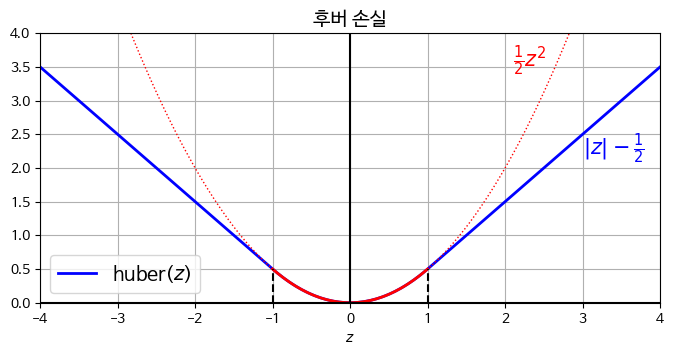

In [72]:
# 추가 코드 - 후버 손실의 모습을 보여줍니다.

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
z_center = np.linspace(-1, 1, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z ** 2 / 2, "r:", linewidth=1)
plt.plot(z_center, z_center ** 2 / 2, "r", linewidth=2)
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "k--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "k--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.text(2.1, 3.5, r"$\frac{1}{2}z^2$", color="r", fontsize=15)
plt.text(3.0, 2.2, r"$|z| - \frac{1}{2}$", color="b", fontsize=15)
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("후버 손실", fontsize=14)
plt.show()

사용자 정의 손실 함수를 테스트하기 위해 기본 케라스 모델을 만들고 캘리포니아 주택 데이터셋으로 훈련해 보겠습니다:

In [73]:
# 추가 코드 - 캘리포니아 주택 데이터셋을 로드, 분할 및 스케일을 조정한 다음 간단한 케라스 모델을 생성합니다.

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

input_shape = X_train.shape[1:]

tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1),
])

In [74]:
model.compile(loss=huber_fn, optimizer="nadam", metrics=["mae"])

In [75]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 7s 7ms/step - loss: 0.4854 - mae: 0.8352 - val_loss: 0.3478 - val_mae: 0.6526
Epoch 2/2
363/363 [==============================] - 2s 6ms/step - loss: 0.2414 - mae: 0.5418 - val_loss: 0.2630 - val_mae: 0.5472


## 사용자 정의 요소를 가진 모델을 저장하고 로드하기

In [76]:
model.save("my_model_with_a_custom_loss")  # 추가 코드 - 정상적으로 저장됩니다.

In [77]:
model = tf.keras.models.load_model("my_model_with_a_custom_loss",
                                   custom_objects={"huber_fn": huber_fn})

In [78]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 4s 5ms/step - loss: 0.2052 - mae: 0.4910 - val_loss: 0.2210 - val_mae: 0.4946
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.1888 - mae: 0.4682 - val_loss: 0.2023 - val_mae: 0.4775


In [79]:
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = threshold * tf.abs(error) - threshold ** 2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn

In [80]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=["mae"])

In [81]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 3s 5ms/step - loss: 0.2051 - mae: 0.4598 - val_loss: 0.2253 - val_mae: 0.4583
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.1982 - mae: 0.4531 - val_loss: 0.2031 - val_mae: 0.4526


In [82]:
model.save("my_model_with_a_custom_loss_threshold_2")

In [83]:
model = tf.keras.models.load_model("my_model_with_a_custom_loss_threshold_2",
                                   custom_objects={"huber_fn": create_huber(2.0)})

In [84]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 4ms/step - loss: 0.1935 - mae: 0.4465 - val_loss: 0.2019 - val_mae: 0.4410
Epoch 2/2
363/363 [==============================] - 1s 4ms/step - loss: 0.1899 - mae: 0.4422 - val_loss: 0.1869 - val_mae: 0.4400


In [85]:
class HuberLoss(tf.keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)

    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [86]:
# 추가 코드 - 간단한 케라스 모델을 또 하나 생성합니다.
tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1),
])

In [87]:
model.compile(loss=HuberLoss(2.), optimizer="nadam", metrics=["mae"])

In [88]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 4ms/step - loss: 0.6486 - mae: 0.8463 - val_loss: 0.5092 - val_mae: 0.6722
Epoch 2/2
363/363 [==============================] - 2s 5ms/step - loss: 0.2911 - mae: 0.5551 - val_loss: 0.3714 - val_mae: 0.5681


In [89]:
model.save("my_model_with_a_custom_loss_class")  # 추가 코드 - 정상 저장

In [90]:
model = tf.keras.models.load_model("my_model_with_a_custom_loss_class",
                                   custom_objects={"HuberLoss": HuberLoss})

In [91]:
# 추가 코드 - 정상적으로 로드되고 모델을 정상적으로 사용할 수 있음을 보여줍니다.
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 4ms/step - loss: 0.2415 - mae: 0.5034 - val_loss: 0.2923 - val_mae: 0.5057
Epoch 2/2
363/363 [==============================] - 1s 4ms/step - loss: 0.2173 - mae: 0.4774 - val_loss: 0.2504 - val_mae: 0.4843


In [92]:
model.loss.threshold  # 추가 코드 - threshold가 올바르게 로드되었습니다.

2.0

## 기타 사용자 정의 기능

In [93]:
def my_softplus(z):
    return tf.math.log(1.0 + tf.exp(z))

def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

def my_positive_weights(weights):  # 반환 값은 tf.nn.relu(weights)입니다.
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

In [94]:
layer = tf.keras.layers.Dense(1, activation=my_softplus,
                              kernel_initializer=my_glorot_initializer,
                              kernel_regularizer=my_l1_regularizer,
                              kernel_constraint=my_positive_weights)

In [95]:
# 추가 코드 - 사용자 정의 요소가 많이 포함된 모델을 빌드, 훈련, 저장, 로드, 훈련할 수 있습니다.

tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1, activation=my_softplus,
                          kernel_initializer=my_glorot_initializer,
                          kernel_regularizer=my_l1_regularizer,
                          kernel_constraint=my_positive_weights)
])
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.save("my_model_with_many_custom_parts")
model = tf.keras.models.load_model(
    "my_model_with_many_custom_parts",
    custom_objects={
       "my_l1_regularizer": my_l1_regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    }
)
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 3s 4ms/step - loss: 1.4714 - mae: 0.8316 - val_loss: inf - val_mae: inf
Epoch 2/2
363/363 [==============================] - 2s 4ms/step - loss: 0.8095 - mae: 0.6172 - val_loss: 2.6156 - val_mae: 0.6058


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'function'>, which may lead to improper serialization.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/regularizers.py:426: UserWarning: The `keras.regularizers.serialize()` API should only be used for objects of type `keras.regularizers.Regularizer`. Found an instance of type <class 'function'>, which may lead to improper serialization.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'function'>, which may lead to improper serialization.
  warnings.warn(


Epoch 1/2
363/363 [==============================] - 3s 4ms/step - loss: 0.6333 - mae: 0.5617 - val_loss: 1.1704 - val_mae: 0.5469
Epoch 2/2
363/363 [==============================] - 1s 4ms/step - loss: 0.5570 - mae: 0.5303 - val_loss: 1.0443 - val_mae: 0.5250


In [96]:
class MyL1Regularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, factor):
        self.factor = factor

    def __call__(self, weights):
        return tf.reduce_sum(tf.abs(self.factor * weights))

    def get_config(self):
        return {"factor": self.factor}

In [97]:
# 추가 코드 - 이번에는 사용자 정의 규제 클래스를 사용하는 경우 정상적으로 작동하는지 보여줍니다.

tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1, activation=my_softplus,
                          kernel_regularizer=MyL1Regularizer(0.01),
                          kernel_constraint=my_positive_weights,
                          kernel_initializer=my_glorot_initializer),
])
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.save("my_model_with_many_custom_parts")
model = tf.keras.models.load_model(
    "my_model_with_many_custom_parts",
    custom_objects={
       "MyL1Regularizer": MyL1Regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    }
)
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 4ms/step - loss: 1.4714 - mae: 0.8316 - val_loss: inf - val_mae: inf
Epoch 2/2
363/363 [==============================] - 1s 4ms/step - loss: 0.8095 - mae: 0.6172 - val_loss: 2.6156 - val_mae: 0.6058


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'function'>, which may lead to improper serialization.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'function'>, which may lead to improper serialization.
  warnings.warn(


Epoch 1/2
363/363 [==============================] - 3s 4ms/step - loss: 0.6333 - mae: 0.5617 - val_loss: 1.1704 - val_mae: 0.5469
Epoch 2/2
363/363 [==============================] - 1s 4ms/step - loss: 0.5570 - mae: 0.5303 - val_loss: 1.0443 - val_mae: 0.5250


## 사용자 정의 지표

In [98]:
# 추가 코드 - 다시 한 번 기본 케라스 모델을 만들어 보겠습니다.
tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1),
])

In [99]:
model.compile(loss="mse", optimizer="nadam", metrics=[create_huber(2.0)])

In [100]:
# 추가 코드 - 사용자 정의 지표로 모델 훈련하기
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
363/363 [==============================] - 2s 3ms/step - loss: 1.7459 - huber_fn: 0.6840
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.7842 - huber_fn: 0.3136


**노트**: 동일한 함수를 손실과 지표로 사용하면 약간 다른 결과에 놀랄 수 있습니다. 이는 부분적으로 연산이 정확히 같은 순서로 계산되지 않아 미세한 부동 소수점 오류가 발생할 수 있기 때문입니다. 더 중요한 것은 샘플 가중치 또는 클래스 가중치를 사용하는 경우 방정식이 약간 달라진다는 것입니다:
* `fit()` 메서드는 에포크 시작 이후 지금까지 본 모든 배치 손실의 평균을 추적합니다. 각 배치 손실은 가중치가 적용된 샘플 손실의 합을 _배치 크기_로 나눈 값입니다. (가중치의 합으로 나눈 것이 아니므로 배치 손실은 손실의 가중 평균이 _아니다_.).
* 에포크 시작 이후의 지표는 가중치가 적용된 샘플 손실의 합을 지금까지 본 모든 가중치의 합으로 나눈 값과 같습니다. 즉, 모든 샘플 손실의 가중 평균입니다. 위와 같지 않습니다.

### 스트리밍 지표

In [101]:
precision = tf.keras.metrics.Precision()
precision([0, 1, 1, 1, 0, 1, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1])

<tf.Tensor: shape=(), dtype=float32, numpy=0.8>

In [102]:
precision([0, 1, 0, 0, 1, 0, 1, 1], [1, 0, 1, 1, 0, 0, 0, 0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [103]:
precision.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [104]:
precision.variables

[<tf.Variable 'true_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>,
 <tf.Variable 'false_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>]

In [105]:
precision.reset_states()

Creating a streaming metric:

In [106]:
class HuberMetric(tf.keras.metrics.Metric):
    def __init__(self, threshold=1.0, **kwargs):
        super().__init__(**kwargs)  # 기본 매개변수 처리 (예를 들어, dtype)
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        self.total = self.add_weight("total", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        sample_metrics = self.huber_fn(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(sample_metrics))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))

    def result(self):
        return self.total / self.count

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

**추가 자료** – 이 섹션의 나머지 부분에서는 `HuberMetric` 클래스를 테스트하고 `tf.keras.metrics.Mean`를 서브클래싱하는 또 다른 예를 보여줍니다.

In [107]:
m = HuberMetric(2.)

# total = 2 * |10 - 2| - 2²/2 = 14
# count = 1
# result = 14 / 1 = 14
m(tf.constant([[2.]]), tf.constant([[10.]]))

<tf.Tensor: shape=(), dtype=float32, numpy=14.0>

In [108]:
# total = total + (|1 - 0|² / 2) + (2 * |9.25 - 5| - 2² / 2) = 14 + 7 = 21
# count = count + 2 = 3
# result = total / count = 21 / 3 = 7
m(tf.constant([[0.], [5.]]), tf.constant([[1.], [9.25]]))

<tf.Tensor: shape=(), dtype=float32, numpy=7.0>

In [109]:
m.result()

<tf.Tensor: shape=(), dtype=float32, numpy=7.0>

In [110]:
m.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=21.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=3.0>]

In [111]:
m.reset_states()
m.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=0.0>]

`HuberMetric` 클래스가 제대로 작동하는지 확인해 보겠습니다:

In [112]:
tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1),
])

In [113]:
model.compile(loss=create_huber(2.0), optimizer="nadam",
              metrics=[HuberMetric(2.0)])

In [114]:
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
363/363 [==============================] - 3s 4ms/step - loss: 0.6486 - huber_metric_1: 0.6486
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.2911 - huber_metric_1: 0.2911


In [115]:
model.save("my_model_with_a_custom_metric")

In [116]:
model = tf.keras.models.load_model(
    "my_model_with_a_custom_metric",
    custom_objects={
        "huber_fn": create_huber(2.0),
        "HuberMetric": HuberMetric
    }
)

In [117]:
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
363/363 [==============================] - 2s 3ms/step - loss: 0.2415 - huber_metric_1: 0.2415
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.2173 - huber_metric_1: 0.2173


`model.metrics`은 모델 손실 다음에 모델의 지표를 담고 있으므로 `HuberMetric`은 `model.metrics[-1]`입니다:

In [118]:
model.metrics[-1].threshold

2.0

잘 작동하는 것 같습니다! 더 간단하게는 다음과 같이 클래스를 만들 수도 있습니다:

In [119]:
class HuberMetric(tf.keras.metrics.Mean):
    def __init__(self, threshold=1.0, name='HuberMetric', dtype=None):
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        super().__init__(name=name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        super(HuberMetric, self).update_state(metric, sample_weight)

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

이 클래스는 크기를 더 잘 처리하며 샘플 가중치도 지원합니다.

In [120]:
tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1),
])

In [121]:
model.compile(loss=tf.keras.losses.Huber(2.0), optimizer="nadam",
              weighted_metrics=[HuberMetric(2.0)])

In [122]:
np.random.seed(42)
sample_weight = np.random.rand(len(y_train))
history = model.fit(X_train_scaled, y_train, epochs=2,
                    sample_weight=sample_weight)

Epoch 1/2
363/363 [==============================] - 2s 3ms/step - loss: 0.3269 - HuberMetric: 0.6587
Epoch 2/2
363/363 [==============================] - 1s 4ms/step - loss: 0.1448 - HuberMetric: 0.2918


In [123]:
(history.history["loss"][0],
 history.history["HuberMetric"][0] * sample_weight.mean())

(0.32688796520233154, 0.3268879972310725)

In [124]:
model.save("my_model_with_a_custom_metric_v2")

In [125]:
model = tf.keras.models.load_model("my_model_with_a_custom_metric_v2",
                                   custom_objects={"HuberMetric": HuberMetric})

In [126]:
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
363/363 [==============================] - 2s 3ms/step - loss: 0.2441 - HuberMetric: 0.2441
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.2184 - HuberMetric: 0.2184


In [127]:
model.metrics[-1].threshold

2.0

## 사용자 정의 층

In [128]:
exponential_layer = tf.keras.layers.Lambda(lambda x: tf.exp(x))

In [129]:
# 추가 코드 - 다른 층과 마찬가지로 함수로 사용할 수 있습니다:
exponential_layer([-1., 0., 1.])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.36787948, 1.        , 2.7182817 ], dtype=float32)>

회귀 모델의 출력에 지수 층을 추가하면 예측할 값이 양수이고 스케일이 매우 다른 경우(예: 0.001, 10., 10000) 유용할 수 있습니다.

In [130]:
tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", input_shape=input_shape),
    tf.keras.layers.Dense(1),
    exponential_layer
])
model.compile(loss="mse", optimizer="sgd")
model.fit(X_train_scaled, y_train, epochs=5,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/5
363/363 [==============================] - 2s 3ms/step - loss: 0.7784 - val_loss: 0.4393
Epoch 2/5
363/363 [==============================] - 1s 3ms/step - loss: 0.5702 - val_loss: 0.4094
Epoch 3/5
363/363 [==============================] - 1s 3ms/step - loss: 0.4431 - val_loss: 0.3760
Epoch 4/5
363/363 [==============================] - 1s 3ms/step - loss: 0.4988 - val_loss: 0.3788
Epoch 5/5
162/162 [==============================] - 0s 2ms/step - loss: 0.3783


0.3782573938369751

또는 타깃을 타깃의 로그로 대체하고 출력 층에서 활성화 함수를 사용하지 않는 것이 더 나을 수 있습니다.

In [131]:
class MyDense(tf.keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name="kernel", shape=[batch_input_shape[-1], self.units],
            initializer="he_normal")
        self.bias = self.add_weight(
            name="bias", shape=[self.units], initializer="zeros")

    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units": self.units,
                "activation": tf.keras.activations.serialize(self.activation)}

In [132]:
# 추가 코드 - 사용자 정의 층을 보통처럼 사용할 수 있음을 보여줍니다.
tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([
    MyDense(30, activation="relu", input_shape=input_shape),
    MyDense(1)
])
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)
model.save("my_model_with_a_custom_layer")

Epoch 1/2
363/363 [==============================] - 3s 4ms/step - loss: 3.1139 - val_loss: 6.9545
Epoch 2/2
162/162 [==============================] - 0s 2ms/step - loss: 0.7037


In [133]:
# 추가 코드 - 사용자 정의 층을 가진 모델을 로드하는 방법을 보여줍니다.
model = tf.keras.models.load_model("my_model_with_a_custom_layer",
                                   custom_objects={"MyDense": MyDense})
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 4ms/step - loss: 0.5943 - val_loss: 0.5311
Epoch 2/2
363/363 [==============================] - 1s 4ms/step - loss: 0.4711 - val_loss: 0.5754


In [134]:
class MyMultiLayer(tf.keras.layers.Layer):
    def call(self, X):
        X1, X2 = X
        print("X1.shape: ", X1.shape ," X2.shape: ", X2.shape)  # extra code
        return X1 + X2, X1 * X2, X1 / X2

사용자 정의 층은 다음과 같이 함수형 API를 사용하여 호출할 수 있습니다:

In [135]:
# 추가 코드 - 심볼릭 입력으로 MyMultiLayer를 테스트합니다.
inputs1 = tf.keras.layers.Input(shape=[2])
inputs2 = tf.keras.layers.Input(shape=[2])
MyMultiLayer()((inputs1, inputs2))

X1.shape:  (None, 2)  X2.shape:  (None, 2)


(<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'my_multi_layer')>,
 <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'my_multi_layer')>,
 <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'my_multi_layer')>)

`call()` 메서드는 심볼릭 입력을 받고 심볼릭 출력을 반환한다는 점에 유의하세요. 이 단계에서는 부분적인 크기만 지정합니다. 배치 크기를 알 수 없기 때문에 첫 번째 차원이 `None`입니다.

실제 데이터를 사용자 정의 층에 전달할 수도 있습니다:

In [136]:
# 추가 코드 - 실제 데이터로 MyMultiLayer를 테스트합니다.
X1, X2 = np.array([[3., 6.], [2., 7.]]), np.array([[6., 12.], [4., 3.]])
MyMultiLayer()((X1, X2))

X1.shape:  (2, 2)  X2.shape:  (2, 2)


(<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[ 9., 18.],
        [ 6., 10.]], dtype=float32)>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[18., 72.],
        [ 8., 21.]], dtype=float32)>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[0.5      , 0.5      ],
        [0.5      , 2.3333333]], dtype=float32)>)

이제 훈련과 테스트 중에 다르게 동작하는 층을 만들어 보겠습니다:

In [137]:
class MyGaussianNoise(tf.keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev

    def call(self, X, training=None):
        if training:
            noise = tf.random.normal(tf.shape(X), stddev=self.stddev)
            return X + noise
        else:
            return X

    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

다음은 이 사용자 정의 층을 사용하는 간단한 모델입니다:

In [138]:
# 추가 코드 - MyGaussianNoise 테스트
tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([
    MyGaussianNoise(stddev=1.0, input_shape=input_shape),
    tf.keras.layers.Dense(30, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1)
])
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
363/363 [==============================] - 4s 4ms/step - loss: 2.2206 - val_loss: 25.1337
Epoch 2/2
162/162 [==============================] - 0s 2ms/step - loss: 1.1054


1.1053950786590576

## 사용자 정의 모델

In [139]:
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu",
                                             kernel_initializer="he_normal")
                       for _ in range(n_layers)]

    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        return inputs + Z

In [140]:
class ResidualRegressor(tf.keras.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = tf.keras.layers.Dense(30, activation="relu",
                                             kernel_initializer="he_normal")
        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.out = tf.keras.layers.Dense(output_dim)

    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(1 + 3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)

In [141]:
# 추가 코드 - 모델을 정상적으로 사용할 수 있음을 보여줍니다.
tf.keras.utils.set_random_seed(42)
model = ResidualRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=2)
score = model.evaluate(X_test_scaled, y_test)
model.save("my_custom_model")

Epoch 1/2
363/363 [==============================] - 5s 6ms/step - loss: 32.6311
Epoch 2/2
162/162 [==============================] - 1s 2ms/step - loss: 1.1566


In [142]:
# 추가 코드 - 모델을 로드하고 훈련을 계속하거나 이를 사용하여 예측을 수행할 수 있습니다.
model = tf.keras.models.load_model("my_custom_model")
history = model.fit(X_train_scaled, y_train, epochs=2)
model.predict(X_test_scaled[:3])

Epoch 1/2
363/363 [==============================] - 4s 5ms/step - loss: 1.3556
Epoch 2/2
1/1 [==============================] - 0s 91ms/step


array([[1.2037897],
       [1.5635332],
       [4.2166495]], dtype=float32)

대신 시퀀셜 API를 사용하여 모델을 정의할 수도 있습니다:

In [143]:
tf.keras.utils.set_random_seed(42)
block1 = ResidualBlock(2, 30)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu",
                          kernel_initializer="he_normal"),
    block1, block1, block1, block1,
    ResidualBlock(2, 30),
    tf.keras.layers.Dense(1)
])

## 모델 구성 요소에 기반한 손실과 지표

**경고**: TF 2.2의 문제([#46858](https://github.com/tensorflow/tensorflow/issues/46858))로 인해 `super().build()`가 실패합니다. 대신 `self.built = True`를 설정하여 이 문제를 해결할 수 있습니다.

In [144]:
class ReconstructingRegressor(tf.keras.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [tf.keras.layers.Dense(30, activation="relu",
                                             kernel_initializer="he_normal")
                       for _ in range(5)]
        self.out = tf.keras.layers.Dense(output_dim)
        self.reconstruction_mean = tf.keras.metrics.Mean(
            name="reconstruction_error")

    def build(self, batch_input_shape):
        n_inputs = batch_input_shape[-1]
        self.reconstruct = tf.keras.layers.Dense(n_inputs)
        self.built = True  # super().build(batch_input_shape)에 대한 해결 방법

    def call(self, inputs, training=None):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        reconstruction = self.reconstruct(Z)
        recon_loss = tf.reduce_mean(tf.square(reconstruction - inputs))
        self.add_loss(0.05 * recon_loss)
        if training:
            result = self.reconstruction_mean(recon_loss)
            self.add_metric(result)
        return self.out(Z)

In [145]:
# 추가 코드
tf.keras.utils.set_random_seed(42)
model = ReconstructingRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
y_pred = model.predict(X_test_scaled)

Epoch 1/5
363/363 [==============================] - 5s 5ms/step - loss: 0.8115 - reconstruction_error: 1.1001
Epoch 2/5
363/363 [==============================] - 2s 5ms/step - loss: 0.4983 - reconstruction_error: 0.5885
Epoch 3/5
363/363 [==============================] - 2s 5ms/step - loss: 0.4232 - reconstruction_error: 0.4467
Epoch 4/5
363/363 [==============================] - 2s 5ms/step - loss: 0.4303 - reconstruction_error: 0.3725
Epoch 5/5
162/162 [==============================] - 0s 2ms/step


## 자동 미분을 사용해 그레이디언트 계산하기

In [146]:
def f(w1, w2):
    return 3 * w1 ** 2 + 2 * w1 * w2

In [147]:
w1, w2 = 5, 3
eps = 1e-6
(f(w1 + eps, w2) - f(w1, w2)) / eps

36.000003007075065

In [148]:
(f(w1, w2 + eps) - f(w1, w2)) / eps

10.000000003174137

In [149]:
w1, w2 = tf.Variable(5.), tf.Variable(3.)
with tf.GradientTape() as tape:
    z = f(w1, w2)

gradients = tape.gradient(z, [w1, w2])

In [150]:
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [151]:
with tf.GradientTape() as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)  # 텐서 36.0를 반환합니다.
try:
    dz_dw2 = tape.gradient(z, w2)  # RuntimeError가 발생합니다!
except RuntimeError as ex:
    print(ex)

A non-persistent GradientTape can only be used to compute one set of gradients (or jacobians)


In [152]:
with tf.GradientTape(persistent=True) as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)  # 텐서 36.0를 반환합니다.
dz_dw2 = tape.gradient(z, w2)  # 텐서 10.0을 반환하고 이제 정상적으로 작동합니다!
del tape

In [153]:
dz_dw1, dz_dw2

(<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>)

In [154]:
c1, c2 = tf.constant(5.), tf.constant(3.)
with tf.GradientTape() as tape:
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])

In [155]:
gradients

[None, None]

In [156]:
with tf.GradientTape() as tape:
    tape.watch(c1)
    tape.watch(c2)
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])

In [157]:
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [158]:
# 추가 코드 - 벡터가 주어지면 tape.gradient()를 사용해 벡터의 합의 그레이디언트을 계산합니다.
with tf.GradientTape() as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)

tape.gradient([z1, z2, z3], [w1, w2])

[<tf.Tensor: shape=(), dtype=float32, numpy=136.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=30.0>]

In [159]:
# 추가 코드 - 이전 셀과 동일한 결과를 얻었음을 보여줍니다.
with tf.GradientTape() as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)
    z = z1 + z2 + z3

tape.gradient(z, [w1, w2])

[<tf.Tensor: shape=(), dtype=float32, numpy=136.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=30.0>]

In [160]:
# 추가 코드 - 야코비안과 헤시안을 계산하는 방법을 보여줍니다.
with tf.GradientTape(persistent=True) as hessian_tape:
    with tf.GradientTape() as jacobian_tape:
        z = f(w1, w2)
    jacobians = jacobian_tape.gradient(z, [w1, w2])
hessians = [hessian_tape.gradient(jacobian, [w1, w2])
            for jacobian in jacobians]
del hessian_tape

In [161]:
jacobians

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [162]:
hessians

[[<tf.Tensor: shape=(), dtype=float32, numpy=6.0>,
  <tf.Tensor: shape=(), dtype=float32, numpy=2.0>],
 [<tf.Tensor: shape=(), dtype=float32, numpy=2.0>, None]]

In [163]:
def f(w1, w2):
    return 3 * w1 ** 2 + tf.stop_gradient(2 * w1 * w2)

with tf.GradientTape() as tape:
    z = f(w1, w2)  # stop_gradient()를 사용하지 않은 경우와 동일한 결과

gradients = tape.gradient(z, [w1, w2])

In [164]:
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=30.0>, None]

In [165]:
x = tf.Variable(1e-50)
with tf.GradientTape() as tape:
    z = tf.sqrt(x)

tape.gradient(z, [x])

[<tf.Tensor: shape=(), dtype=float32, numpy=inf>]

In [166]:
tf.math.log(tf.exp(tf.constant(30., dtype=tf.float32)) + 1.)

<tf.Tensor: shape=(), dtype=float32, numpy=30.0>

In [167]:
x = tf.Variable([1.0e30])
with tf.GradientTape() as tape:
    z = my_softplus(x)

tape.gradient(z, [x])

[<tf.Tensor: shape=(1,), dtype=float32, numpy=array([nan], dtype=float32)>]

In [168]:
def my_softplus(z):
    return tf.math.log(1 + tf.exp(-tf.abs(z))) + tf.maximum(0., z)

다음은 이 방정식이 log(1 + exp(_z_))와 같다는 것을 증명하는 예입니다:
* softplus(_z_) = log(1 + exp(_z_))
* softplus(_z_) = log(1 + exp(_z_)) - log(exp(_z_)) + log(exp(_z_)) ; **같은 값을 더하고 뺍니다**
* softplus(_z_) = log\[(1 + exp(_z_)) / exp(_z_)\] + log(exp(_z_)) ; **since log(_a_) - log(_b_) = log(_a_ / _b_)**
* softplus(_z_) = log\[(1 + exp(_z_)) / exp(_z_)\] + _z_ ; **since log(exp(_z_)) = _z_**
* softplus(_z_) = log\[1 / exp(_z_) + exp(_z_) / exp(_z_)\] + _z_ ; **since (1 + _a_) / _b_ = 1 / _b_ + _a_ / _b_**
* softplus(_z_) = log\[exp(–_z_) + 1\] + _z_ ; **1 / exp(_z_) = exp(–z)이고 exp(_z_) / exp(_z_) = 1 이므로**
* softplus(_z_) = softplus(–_z_) + _z_ ; **맨 위의 정의를 사용합니다. 다만 –_z_ 입니다**
* softplus(_z_) = softplus(–|_z_|) + max(0, _z_) ; **_z_ < 0 나 _z_ ≥ 0 인 경우를 고려하면**

In [169]:
@tf.custom_gradient
def my_softplus(z):
    def my_softplus_gradients(grads):  # grads = 상위 층에서 역전파된 그레이디언트
        return grads * (1 - 1 / (1 + tf.exp(z)))  # 안정적인 소프트플러스 그레이디언트

    result = tf.math.log(1 + tf.exp(-tf.abs(z))) + tf.maximum(0., z)
    return result, my_softplus_gradients

In [170]:
# 추가 코드 - 함수와 이 함수의 그레이디언트가 안정적임을 보여줍니다.
x = tf.Variable([1000.])
with tf.GradientTape() as tape:
    z = my_softplus(x)

z, tape.gradient(z, [x])

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1000.], dtype=float32)>,
 [<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>])

## 사용자 정의 훈련

In [171]:
tf.keras.utils.set_random_seed(42)  # 추가 코드 - 재현성 보장
l2_reg = tf.keras.regularizers.l2(0.05)
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          kernel_regularizer=l2_reg),
    tf.keras.layers.Dense(1, kernel_regularizer=l2_reg)
])

In [172]:
def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]

In [173]:
def print_status_bar(step, total, loss, metrics=None):
    metrics = " - ".join([f"{m.name}: {m.result():.4f}"
                          for m in [loss] + (metrics or [])])
    end = "" if step < total else "\n"
    print(f"\r{step}/{total} - " + metrics, end=end)

In [174]:
tf.keras.utils.set_random_seed(42)

In [175]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
loss_fn = tf.keras.losses.mean_squared_error
mean_loss = tf.keras.metrics.Mean()
metrics = [tf.keras.metrics.MeanAbsoluteError()]

In [176]:
for epoch in range(1, n_epochs + 1):
    print(f"Epoch {epoch}/{n_epochs}")
    for step in range(1, n_steps + 1):
        X_batch, y_batch = random_batch(X_train_scaled, y_train)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch, training=True)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # 추가 코드 - 모델 변수에 제약이 있는 경우
        for variable in model.variables:
            if variable.constraint is not None:
                variable.assign(variable.constraint(variable))

        mean_loss(loss)
        for metric in metrics:
            metric(y_batch, y_pred)

        print_status_bar(step, n_steps, mean_loss, metrics)

    for metric in [mean_loss] + metrics:
        metric.reset_states()

Epoch 1/5
362/362 - mean: 3.5419 - mean_absolute_error: 0.6640
Epoch 2/5
362/362 - mean: 1.8693 - mean_absolute_error: 0.5431
Epoch 3/5
362/362 - mean: 1.1428 - mean_absolute_error: 0.5030
Epoch 4/5
362/362 - mean: 0.8501 - mean_absolute_error: 0.4977
Epoch 5/5
362/362 - mean: 0.7280 - mean_absolute_error: 0.5014


In [177]:
# 추가 코드 - tqdm 패키지를 사용하여 멋진 진행률 표시줄을 표시하는 방법을 보여줍니다.

from tqdm.notebook import trange
from collections import OrderedDict
with trange(1, n_epochs + 1, desc="All epochs") as epochs:
    for epoch in epochs:
        with trange(1, n_steps + 1, desc=f"Epoch {epoch}/{n_epochs}") as steps:
            for step in steps:
                X_batch, y_batch = random_batch(X_train_scaled, y_train)
                with tf.GradientTape() as tape:
                    y_pred = model(X_batch)
                    main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                    loss = tf.add_n([main_loss] + model.losses)

                gradients = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))

                for variable in model.variables:
                    if variable.constraint is not None:
                        variable.assign(variable.constraint(variable))

                status = OrderedDict()
                mean_loss(loss)
                status["loss"] = mean_loss.result().numpy()
                for metric in metrics:
                    metric(y_batch, y_pred)
                    status[metric.name] = metric.result().numpy()

                steps.set_postfix(status)

        for metric in [mean_loss] + metrics:
            metric.reset_states()

All epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/362 [00:00<?, ?it/s]

## 텐서플로 함수

In [178]:
def cube(x):
    return x ** 3

In [179]:
cube(2)

8

In [180]:
cube(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [181]:
tf_cube = tf.function(cube)
tf_cube

In [182]:
tf_cube(2)

<tf.Tensor: shape=(), dtype=int32, numpy=8>

In [183]:
tf_cube(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [184]:
@tf.function
def tf_cube(x):
    return x ** 3

**노트:** 이 섹션의 나머지 코드는 부록 D의 내용입니다.

### TF 함수와 콘크리트 함수

In [185]:
concrete_function = tf_cube.get_concrete_function(tf.constant(2.0))
concrete_function

<ConcreteFunction (x: TensorSpec(shape=(), dtype=tf.float32, name=None)) -> TensorSpec(shape=(), dtype=tf.float32, name=None) at 0x7CF0AEEF2710>

In [186]:
concrete_function(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [187]:
concrete_function is tf_cube.get_concrete_function(tf.constant(2.0))

True

### 함수 정의와 그래프 탐험하기

In [188]:
concrete_function.graph

In [189]:
ops = concrete_function.graph.get_operations()
ops

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'pow/y' type=Const>,
 <tf.Operation 'pow' type=Pow>,
 <tf.Operation 'Identity' type=Identity>]

In [190]:
pow_op = ops[2]
list(pow_op.inputs)

[<tf.Tensor 'x:0' shape=() dtype=float32>,
 <tf.Tensor 'pow/y:0' shape=() dtype=float32>]

In [191]:
pow_op.outputs

[<tf.Tensor 'pow:0' shape=() dtype=float32>]

In [192]:
concrete_function.graph.get_operation_by_name('x')

<tf.Operation 'x' type=Placeholder>

In [193]:
concrete_function.graph.get_tensor_by_name('Identity:0')

<tf.Tensor 'Identity:0' shape=() dtype=float32>

In [194]:
concrete_function.function_def.signature

name: "__inference_tf_cube_470259"
input_arg {
  name: "x"
  type: DT_FLOAT
}
output_arg {
  name: "identity"
  type: DT_FLOAT
}

### TF 함수가 파이썬 함수를 트레이싱하여 계산 그래프를 추출하는 방법

In [195]:
@tf.function
def tf_cube(x):
    print(f"x = {x}")
    return x ** 3

In [196]:
result = tf_cube(tf.constant(2.0))

x = Tensor("x:0", shape=(), dtype=float32)


In [197]:
result

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [198]:
result = tf_cube(2)

x = 2


In [199]:
result = tf_cube(3)

x = 3


In [200]:
result = tf_cube(tf.constant([[1., 2.]]))  # 새로운 크기: 트레이싱!

x = Tensor("x:0", shape=(1, 2), dtype=float32)


In [201]:
result = tf_cube(tf.constant([[3., 4.], [5., 6.]]))  # 새로운 크기: 트레이싱!

x = Tensor("x:0", shape=(2, 2), dtype=float32)


In [202]:
result = tf_cube(tf.constant([[7., 8.], [9., 10.]]))  # 같은 크기: 트레이싱 없음

It is also possible to specify a particular input signature:

In [203]:
@tf.function(input_signature=[tf.TensorSpec([None, 28, 28], tf.float32)])
def shrink(images):
    print("Tracing", images)  # 트레이싱을 출력하는 추가 코드
    return images[:, ::2, ::2] # 행과 열의 절반을 삭제합니다.

In [204]:
tf.keras.utils.set_random_seed(42)

In [205]:
img_batch_1 = tf.random.uniform(shape=[100, 28, 28])
img_batch_2 = tf.random.uniform(shape=[50, 28, 28])
preprocessed_images = shrink(img_batch_1)  # 정상 작동, 함수 트레이싱
preprocessed_images = shrink(img_batch_2)  # 정상 작동, 동일한 콘크리트 함수

Tracing Tensor("images:0", shape=(None, 28, 28), dtype=float32)


In [206]:
img_batch_3 = tf.random.uniform(shape=[2, 2, 2])
try:
    preprocessed_images = shrink(img_batch_3)  # ValueError! 호환되지 않는 입력
except ValueError as ex:
    print(ex)

TypeError: Binding inputs to tf.function failed due to `Can not cast TensorSpec(shape=(2, 2, 2), dtype=tf.float32, name=None) to TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name=None)`. Received args: (<tf.Tensor: shape=(2, 2, 2), dtype=float32, numpy=
array([[[0.7413678 , 0.62854624],
        [0.01738465, 0.3431449 ]],

       [[0.51063764, 0.3777541 ],
        [0.07321596, 0.02137029]]], dtype=float32)>,) and kwargs: {} for signature: (images: TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name=None)).

### Autograph를 사용해 제어 흐름 표현하기

`range()`를 사용하는 "정적" `for` 루프입니다:

In [207]:
@tf.function
def add_10(x):
    for i in range(10):
        x += 1
    return x

In [208]:
add_10(tf.constant(5))

<tf.Tensor: shape=(), dtype=int32, numpy=15>

In [209]:
add_10.get_concrete_function(tf.constant(5)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'add/y' type=Const>,
 <tf.Operation 'add' type=AddV2>,
 <tf.Operation 'add_1/y' type=Const>,
 <tf.Operation 'add_1' type=AddV2>,
 <tf.Operation 'add_2/y' type=Const>,
 <tf.Operation 'add_2' type=AddV2>,
 <tf.Operation 'add_3/y' type=Const>,
 <tf.Operation 'add_3' type=AddV2>,
 <tf.Operation 'add_4/y' type=Const>,
 <tf.Operation 'add_4' type=AddV2>,
 <tf.Operation 'add_5/y' type=Const>,
 <tf.Operation 'add_5' type=AddV2>,
 <tf.Operation 'add_6/y' type=Const>,
 <tf.Operation 'add_6' type=AddV2>,
 <tf.Operation 'add_7/y' type=Const>,
 <tf.Operation 'add_7' type=AddV2>,
 <tf.Operation 'add_8/y' type=Const>,
 <tf.Operation 'add_8' type=AddV2>,
 <tf.Operation 'add_9/y' type=Const>,
 <tf.Operation 'add_9' type=AddV2>,
 <tf.Operation 'Identity' type=Identity>]

`tf.while_loop()`를 사용하는 "동적" 루프입니다:

In [210]:
# 추가 코드 - tf.while_loop를 사용하는 방법을 보여줍니다(일반적으로 @tf.function이 더 간단합니다).
@tf.function
def add_10(x):
    condition = lambda i, x: tf.less(i, 10)
    body = lambda i, x: (tf.add(i, 1), tf.add(x, 1))
    final_i, final_x = tf.while_loop(condition, body, [tf.constant(0), x])
    return final_x

In [211]:
add_10(tf.constant(5))

<tf.Tensor: shape=(), dtype=int32, numpy=15>

In [212]:
add_10.get_concrete_function(tf.constant(5)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'Const' type=Const>,
 <tf.Operation 'while/maximum_iterations' type=Const>,
 <tf.Operation 'while/loop_counter' type=Const>,
 <tf.Operation 'while' type=StatelessWhile>,
 <tf.Operation 'Identity' type=Identity>]

(autograph가 감지한) `tf.range()`를 사용하는 "동적" `for` 루프:

In [213]:
@tf.function
def add_10(x):
    for i in tf.range(10):
        x = x + 1
    return x

In [214]:
add_10.get_concrete_function(tf.constant(0)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'range/start' type=Const>,
 <tf.Operation 'range/limit' type=Const>,
 <tf.Operation 'range/delta' type=Const>,
 <tf.Operation 'range' type=Range>,
 <tf.Operation 'sub' type=Sub>,
 <tf.Operation 'floordiv' type=FloorDiv>,
 <tf.Operation 'mod' type=FloorMod>,
 <tf.Operation 'zeros_like' type=Const>,
 <tf.Operation 'NotEqual' type=NotEqual>,
 <tf.Operation 'Cast' type=Cast>,
 <tf.Operation 'add' type=AddV2>,
 <tf.Operation 'zeros_like_1' type=Const>,
 <tf.Operation 'Maximum' type=Maximum>,
 <tf.Operation 'while/maximum_iterations' type=Const>,
 <tf.Operation 'while/loop_counter' type=Const>,
 <tf.Operation 'while' type=StatelessWhile>,
 <tf.Operation 'Identity' type=Identity>]

### TF 함수에서 변수와 다른 리소스 다루기

In [215]:
counter = tf.Variable(0)

@tf.function
def increment(counter, c=1):
    return counter.assign_add(c)

increment(counter)  # counter는 이제 1과 같습니다.
increment(counter)  # counter는 이제 2와 같습니다.

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [216]:
function_def = increment.get_concrete_function(counter).function_def
function_def.signature.input_arg[0]

name: "counter"
type: DT_RESOURCE

In [217]:
counter = tf.Variable(0)

@tf.function
def increment(c=1):
    return counter.assign_add(c)

In [218]:
increment()
increment()

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [219]:
function_def = increment.get_concrete_function().function_def
function_def.signature.input_arg[0]

name: "assignaddvariableop_resource"
type: DT_RESOURCE

In [220]:
class Counter:
    def __init__(self):
        self.counter = tf.Variable(0)

    @tf.function
    def increment(self, c=1):
        return self.counter.assign_add(c)

In [221]:
c = Counter()
c.increment()
c.increment()

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [222]:
@tf.function
def add_10(x):
    for i in tf.range(10):
        x += 1
    return x

print(tf.autograph.to_code(add_10.python_function))

def tf__add(x):
    with ag__.FunctionScope('add_10', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()

        def get_state():
            return (x,)

        def set_state(vars_):
            nonlocal x
            (x,) = vars_

        def loop_body(itr):
            nonlocal x
            i = itr
            x = ag__.ld(x)
            x += 1
        i = ag__.Undefined('i')
        ag__.for_stmt(ag__.converted_call(ag__.ld(tf).range, (10,), None, fscope), None, loop_body, get_state, set_state, ('x',), {'iterate_names': 'i'})
        try:
            do_return = True
            retval_ = ag__.ld(x)
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)



In [223]:
# 추가 코드 - 구문 강조 표시로 autograph 코드를 표시하는 방법을 보여줍니다.
def display_tf_code(func):
    from IPython.display import display, Markdown
    if hasattr(func, "python_function"):
        func = func.python_function
    code = tf.autograph.to_code(func)
    display(Markdown(f'```python\n{code}\n```'))

In [224]:
display_tf_code(add_10)

```python
def tf__add(x):
    with ag__.FunctionScope('add_10', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()

        def get_state():
            return (x,)

        def set_state(vars_):
            nonlocal x
            (x,) = vars_

        def loop_body(itr):
            nonlocal x
            i = itr
            x = ag__.ld(x)
            x += 1
        i = ag__.Undefined('i')
        ag__.for_stmt(ag__.converted_call(ag__.ld(tf).range, (10,), None, fscope), None, loop_body, get_state, set_state, ('x',), {'iterate_names': 'i'})
        try:
            do_return = True
            retval_ = ag__.ld(x)
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)

```

## 케라스에 TF 함수 사용하기(또는 사용하지 않기)

기본적으로 tf.keras는 사용자 지정 코드를 TF 함수로 자동 변환하므로 `tf.function()`을 사용할 필요가 없습니다:

In [225]:
# 사용자 정의 손실 함수
def my_mse(y_true, y_pred):
    print("손실 my_mse() 트레이싱")
    return tf.reduce_mean(tf.square(y_pred - y_true))

In [226]:
# 사용자 정의 지표 함수
def my_mae(y_true, y_pred):
    print("지표 my_mae() 트레이싱")
    return tf.reduce_mean(tf.abs(y_pred - y_true))

In [227]:
# 사용자 정의 층
class MyDense(tf.keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel',
                                      shape=(input_shape[1], self.units),
                                      initializer='uniform',
                                      trainable=True)
        self.biases = self.add_weight(name='bias',
                                      shape=(self.units,),
                                      initializer='zeros',
                                      trainable=True)
        super().build(input_shape)

    def call(self, X):
        print("MyDense.call() 트레이싱")
        return self.activation(X @ self.kernel + self.biases)

In [228]:
tf.keras.utils.set_random_seed(42)

In [229]:
# 사용자 정의 모델
class MyModel(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = MyDense(30, activation="relu")
        self.hidden2 = MyDense(30, activation="relu")
        self.output_ = MyDense(1)

    def call(self, input):
        print("MyModel.call() 트레이싱")
        hidden1 = self.hidden1(input)
        hidden2 = self.hidden2(hidden1)
        concat = tf.keras.layers.concatenate([input, hidden2])
        output = self.output_(concat)
        return output

model = MyModel()

In [230]:
model.compile(loss=my_mse, optimizer="nadam", metrics=[my_mae])

In [231]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
손실 my_mse() 트레이싱
지표 my_mae() 트레이싱
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
손실 my_mse() 트레이싱
지표 my_mae() 트레이싱
359/363 [============================>.] - ETA: 0s - loss: 1.4387 - my_mae: 0.8244MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
손실 my_mse() 트레이싱
지표 my_mae() 트레이싱
363/363 [==============================] - 3s 4ms/step - loss: 1.4293 - my_mae: 0.8214 - val_loss: 0.4888 - val_my_mae: 0.4757
Epoch 2/2
162/162 [==============================] - 0s 3ms/step - loss: 0.4214 - my_mae: 0.4710


[0.4213947057723999, 0.47099101543426514]

이 기능은 `dynamic=True`로 모델을 생성하거나 모델 생성자에서 `super().__init__(dynamic=True, **kwargs)`를 호출하여 해제할 수 있습니다:

In [232]:
tf.keras.utils.set_random_seed(42)

In [233]:
model = MyModel(dynamic=True)

In [234]:
model.compile(loss=my_mse, optimizer="nadam", metrics=[my_mae])

이제 사용자 정의 코드가 각 반복마다 호출됩니다. 너무 많은 출력을 피하기 위해 작은 데이터셋으로 검증과 평가를 수행해 보겠습니다:

In [235]:
model.fit(X_train_scaled[:64], y_train[:64], epochs=1,
          validation_data=(X_valid_scaled[:64], y_valid[:64]), verbose=0)
model.evaluate(X_test_scaled[:64], y_test[:64], verbose=0)

MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
손실 my_mse() 트레이싱


지표 my_mae() 트레이싱
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
손실 my_mse() 트레이싱
지표 my_mae() 트레이싱
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
손실 my_mse() 트레이싱
지표 my_mae() 트레이싱
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
손실 my_mse() 트레이싱
지표 my_mae() 트레이싱
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
손실 my_mse() 트레이싱
지표 my_mae() 트레이싱
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
손실 my_mse() 트레이싱
지표 my_mae() 트레이싱


[5.549154281616211, 2.0611484050750732]

또는 `run_eagerly=True`로 모델을 컴파일할 수 있습니다:

In [236]:
tf.keras.utils.set_random_seed(42)

In [237]:
model = MyModel()

In [238]:
model.compile(loss=my_mse, optimizer="nadam", metrics=[my_mae], run_eagerly=True)

In [239]:
model.fit(X_train_scaled[:64], y_train[:64], epochs=1,
          validation_data=(X_valid_scaled[:64], y_valid[:64]), verbose=0)
model.evaluate(X_test_scaled[:64], y_test[:64], verbose=0)

MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
손실 my_mse() 트레이싱
지표 my_mae() 트레이싱
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
손실 my_mse() 트레이싱
지표 my_mae() 트레이싱
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
손실 my_mse() 트레이싱
지표 my_mae() 트레이싱
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
손실 my_mse() 트레이싱
지표 my_mae() 트레이싱
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
손실 my_mse() 트레이싱
지표 my_mae() 트레이싱
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
손실 my_mse() 트레이싱
지표 my_mae() 트레이싱


[5.549154281616211, 2.0611484050750732]

## 추가 자료 - 사용자 정의 옵티마이저

사용자 정의 옵티마이저를 정의하는 것은 그리 일반적이지 않지만, 만약 여러분이 옵티마이저를 작성해야 한다면 다음 예시를 참고하세요:

In [240]:
class MyMomentumOptimizer(tf.keras.optimizers.Optimizer):
    def __init__(self, learning_rate=0.001, momentum=0.0, name="MyMomentumOptimizer", **kwargs):
        super().__init__(name, **kwargs)
        self._learning_rate = self._build_learning_rate(learning_rate)
        self.momentum = momentum

    def build(self, var_list):
        """옵티마이저 변수 초기화
        매개변수:
          var_list: 모델 변수 목록
        """
        super().build(var_list)
        if hasattr(self, "_built") and self._built:
            return
        self.momentums = []
        for var in var_list:
            self.momentums.append(
                self.add_variable_from_reference(
                    model_variable=var, variable_name="m"
                )
            )
        self._built = True

    def update_step(self, gradient, variable):
        """주어진 그레이디언트와 관련된 모델 변수로 스텝을 업데이트합니다."""
        lr = tf.cast(self.learning_rate, variable.dtype)
        m = None
        var_key = self._var_key(variable)
        momentum = tf.cast(self.momentum, variable.dtype)
        m = self.momentums[self._index_dict[var_key]]

        if isinstance(gradient, tf.IndexedSlices):
            # 희소한 그레이디언트
            add_value = tf.IndexedSlices(
                -gradient.values * lr, gradient.indices
            )
            if m is not None:
                m.assign(m * momentum)
                m.scatter_add(add_value)
                variable.assign_add(m)
            else:
                variable.scatter_add(add_value)
        else:
            # 밀집 그레이디언트
            if m is not None:
                m.assign(-gradient * lr + m * momentum)
                variable.assign_add(m)
            else:
                variable.assign_add(-gradient * lr)

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "learning_rate": self._serialize_hyperparameter(self._learning_rate),
            "momentum": self._serialize_hyperparameter(self.momentum),
        }

In [241]:
optimizer = MyMomentumOptimizer()

tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([tf.keras.layers.Dense(1, input_shape=[8])])
model.compile(loss="mse", optimizer=optimizer)
model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
363/363 [==============================] - 1s 2ms/step - loss: 4.0546
Epoch 2/5
363/363 [==============================] - 1s 2ms/step - loss: 1.2763
Epoch 3/5
363/363 [==============================] - 1s 2ms/step - loss: 0.7623
Epoch 4/5
363/363 [==============================] - 1s 2ms/step - loss: 0.6428
Epoch 5/5
363/363 [==============================] - 1s 2ms/step - loss: 0.6102


케라스에 내장된 모멘텀 옵티마이저와 비교해 보죠.

In [242]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([tf.keras.layers.Dense(1, input_shape=[8])])
model.compile(loss="mse", optimizer=optimizer)
model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
363/363 [==============================] - 1s 2ms/step - loss: 1.1844
Epoch 2/5
363/363 [==============================] - 1s 2ms/step - loss: 0.5635
Epoch 3/5
363/363 [==============================] - 1s 3ms/step - loss: 0.9703
Epoch 4/5
363/363 [==============================] - 1s 3ms/step - loss: 0.5678
Epoch 5/5
363/363 [==============================] - 1s 2ms/step - loss: 0.6350


# 연습문제 해답

## 1. to 11.

부록 A 참조

## 12. _층 정규화_ 를 수행하는 사용자 정의 층을 구현하세요.

_15장에서 순환 신경망을 사용할 때 이런 종류의 층을 사용합니다._

### a.
_문제: `build()` 메서드에서 두 개의 훈련 가능한 가중치 *α*와 *β*를 정의합니다. 두 가중치 모두 크기가 `input_shape[-1:]`이고 데이터 타입은 `tf.float32`입니다. *α*는 1로 초기화되고 *β*는 0으로 초기화되어야 합니다._

솔루션: 아래 참조.

### b.
_문제: `call()` 메서드는 샘플의 특성마다 평균 μ와 표준편차 σ를 계산해야 합니다. 이를 위해 전체 샘플의 평균 μ와 분산 σ<sup>2</sup>을 반환하는 `tf.nn.moments(inputs, axes=-1, keepdims=True)`을 사용할 수 있습니다(분산의 제곱근으로 표준편차를 계산합니다). 그다음 *α*⊗(*X* - μ)/(σ + ε) + *β*를 계산하여 반환합니다. 여기에서 ⊗는 원소별
곱셈(`*`)을 나타냅니다. ε은 안전을 위한 항입니다(0으로 나누어지는 것을 막기 위한 작은 상수. 예를 들면 0.001)._

In [243]:
class LayerNormalization(tf.keras.layers.Layer):
    def __init__(self, eps=0.001, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps

    def build(self, batch_input_shape):
        self.alpha = self.add_weight(
            name="alpha", shape=batch_input_shape[-1:],
            initializer="ones")
        self.beta = self.add_weight(
            name="beta", shape=batch_input_shape[-1:],
            initializer="zeros")
        super().build(batch_input_shape) # 반드시 끝에 와야 합니다

    def call(self, X):
        mean, variance = tf.nn.moments(X, axes=-1, keepdims=True)
        return self.alpha * (X - mean) / (tf.sqrt(variance + self.eps)) + self.beta

    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "eps": self.eps}

_ε_ 하이퍼파라미터(`eps`)는 필수가 아닙니다. 또한 `tf.sqrt(variance) + self.eps` 보다 `tf.sqrt(variance + self.eps)`를 계산하는 것이 좋습니다. sqrt(z)의 도함수는 z=0에서 정의되지 않기 때문에 분산 벡터의 한 원소가 0에 가까우면 훈련이 이리저리 널뜁니다. 제곱근 안에 _ε_를 넣으면 이런 현상을 방지할 수 있습니다.

### c.
_문제: 사용자 정의 층이 `tf.keras.layers.LayerNormalization` 층과 동일한(또는 거의 동일한) 출력을 만드는지 확인하세요._

각 클래스의 객체를 만들고 데이터(예를 들면, 훈련 세트)를 적용해 보죠. 차이는 무시할 수 있는 수준입니다.

In [244]:
X = X_train.astype(np.float32)

custom_layer_norm = LayerNormalization()
keras_layer_norm = tf.keras.layers.LayerNormalization()

tf.reduce_mean(tf.keras.losses.mean_absolute_error(
    keras_layer_norm(X), custom_layer_norm(X)))

<tf.Tensor: shape=(), dtype=float32, numpy=3.894674e-08>

네 충분히 가깝네요. 조금 더 확실하게 알파와 베타를 완전히 랜덤하게 지정하고 다시 비교해 보죠:

In [245]:
tf.keras.utils.set_random_seed(42)
random_alpha = np.random.rand(X.shape[-1])
random_beta = np.random.rand(X.shape[-1])

custom_layer_norm.set_weights([random_alpha, random_beta])
keras_layer_norm.set_weights([random_alpha, random_beta])

tf.reduce_mean(tf.keras.losses.mean_absolute_error(
    keras_layer_norm(X), custom_layer_norm(X)))

<tf.Tensor: shape=(), dtype=float32, numpy=1.7224725e-08>

여전히 무시할 수 있는 수준입니다! 사용자 정의 층이 잘 동작합니다.

## 13. 사용자 정의 훈련 반복을 사용해 패션 MNIST 데이터셋으로 모델을 훈련해보세요.

_패션 MNIST 데이터셋은 10장에서 소개했습니다._

### a.
_문제: 에포크, 반복, 평균 훈련 손실, (반복마다 업데이트되는) 에포크의 평균 정확도는 물론 에포크 끝에서 검증 손실과 정확도를 출력하세요._

In [246]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255.
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test.astype(np.float32) / 255.

4422102/4422102 [==============================] - 0s 0us/step


In [247]:
tf.keras.utils.set_random_seed(42)

In [248]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax"),
])

In [249]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
mean_loss = tf.keras.metrics.Mean()
metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]

In [250]:
with trange(1, n_epochs + 1, desc="All epochs") as epochs:
    for epoch in epochs:
        with trange(1, n_steps + 1, desc=f"Epoch {epoch}/{n_epochs}") as steps:
            for step in steps:
                X_batch, y_batch = random_batch(X_train, y_train)
                with tf.GradientTape() as tape:
                    y_pred = model(X_batch)
                    main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                    loss = tf.add_n([main_loss] + model.losses)
                gradients = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                for variable in model.variables:
                    if variable.constraint is not None:
                        variable.assign(variable.constraint(variable))
                status = OrderedDict()
                mean_loss(loss)
                status["loss"] = mean_loss.result().numpy()
                for metric in metrics:
                    metric(y_batch, y_pred)
                    status[metric.name] = metric.result().numpy()
                steps.set_postfix(status)
            y_pred = model(X_valid)
            status["val_loss"] = np.mean(loss_fn(y_valid, y_pred))
            status["val_accuracy"] = np.mean(tf.keras.metrics.sparse_categorical_accuracy(
                tf.constant(y_valid, dtype=np.float32), y_pred))
            steps.set_postfix(status)
        for metric in [mean_loss] + metrics:
            metric.reset_states()


All epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/1718 [00:00<?, ?it/s]

### b.
_문제: 상위 층과 하위 층에 학습률이 다른 옵티마이저를 따로 사용해보세요._

In [251]:
tf.keras.utils.set_random_seed(42)

In [252]:
lower_layers = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu"),
])
upper_layers = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation="softmax"),
])
model = tf.keras.Sequential([
    lower_layers, upper_layers
])

In [253]:
lower_optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
upper_optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-3)

In [254]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
mean_loss = tf.keras.metrics.Mean()
metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]

In [255]:
with trange(1, n_epochs + 1, desc="All epochs") as epochs:
    for epoch in epochs:
        with trange(1, n_steps + 1, desc=f"Epoch {epoch}/{n_epochs}") as steps:
            for step in steps:
                X_batch, y_batch = random_batch(X_train, y_train)
                with tf.GradientTape(persistent=True) as tape:
                    y_pred = model(X_batch)
                    main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                    loss = tf.add_n([main_loss] + model.losses)
                for layers, optimizer in ((lower_layers, lower_optimizer),
                                          (upper_layers, upper_optimizer)):
                    gradients = tape.gradient(loss, layers.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, layers.trainable_variables))
                del tape
                for variable in model.variables:
                    if variable.constraint is not None:
                        variable.assign(variable.constraint(variable))
                status = OrderedDict()
                mean_loss(loss)
                status["loss"] = mean_loss.result().numpy()
                for metric in metrics:
                    metric(y_batch, y_pred)
                    status[metric.name] = metric.result().numpy()
                steps.set_postfix(status)
            y_pred = model(X_valid)
            status["val_loss"] = np.mean(loss_fn(y_valid, y_pred))
            status["val_accuracy"] = np.mean(tf.keras.metrics.sparse_categorical_accuracy(
                tf.constant(y_valid, dtype=np.float32), y_pred))
            steps.set_postfix(status)
        for metric in [mean_loss] + metrics:
            metric.reset_states()

All epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/1718 [00:00<?, ?it/s]